# Executive Summary

- Overview
    - This noteboook uses a tweedie GLM approach
    - Uses miles driven for model weights and pure prem
    - Predicts on ILAE and allocates to loss and expenses
    - Final model uses vehicle type, driver safety score, and driver years of experience

- Next Steps
    - Test model on holdout data
    - Select guideline model factors
    - Communicate model results to stakeholders
    - Included comments and TODOs for future models
    - Let me know if you have any questions! (Patrick Bischke)

# Imports and Configs

In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn import preprocessing
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from matplotlib import pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

In [3]:
train = pd.read_csv('Documents/train.csv')
test = pd.read_csv('Documents/test.csv')

# TODO: With more time, create a holdout dataset 
# to assess model performance
# train=train_test.sample(frac=0.7,random_state=42)
# holdout=train_test.drop(train.index)

# ETL

In [5]:
def etl(df, training=True):

    # We're going to use date_latest_delivery as
    # our temporal control, which acts as a proxy for
    # date_of_loss
    try:
        df= df.drop(columns='date_of_loss')
    except KeyError:
        pass
    
    # Some numeric cols are stored as strings, convert those cols to numeric
    if training:
        parse_to_num = ['miles_driven',
                        'incurred_loss_bodily_injury',
                        'incurred_legal_expenses']
    else:
        parse_to_num = ['miles_driven']
    
    df[parse_to_num] = (df[parse_to_num].replace(r'[\$,]', '', regex=True)
                           .astype(float)
                           .fillna(0))
    
    
    # convert strings to datetime
    parse_to_date = ['date_latest_delivery',
                     'date_first_delivery',
                     'date_of_birth']
    
    for _, col in enumerate(parse_to_date):
        df[col] = pd.to_datetime(df[col],errors='coerce')

    return df.copy()


array([[<Axes: title={'center': 'driver_id'}>,
        <Axes: title={'center': 'miles_driven'}>,
        <Axes: title={'center': 'driver_safety_score'}>],
       [<Axes: title={'center': 'date_latest_delivery'}>,
        <Axes: title={'center': 'date_first_delivery'}>,
        <Axes: title={'center': 'date_of_birth'}>],
       [<Axes: title={'center': 'claim_closed_ind'}>,
        <Axes: title={'center': 'incurred_loss_bodily_injury'}>,
        <Axes: title={'center': 'incurred_legal_expenses'}>]],
      dtype=object)

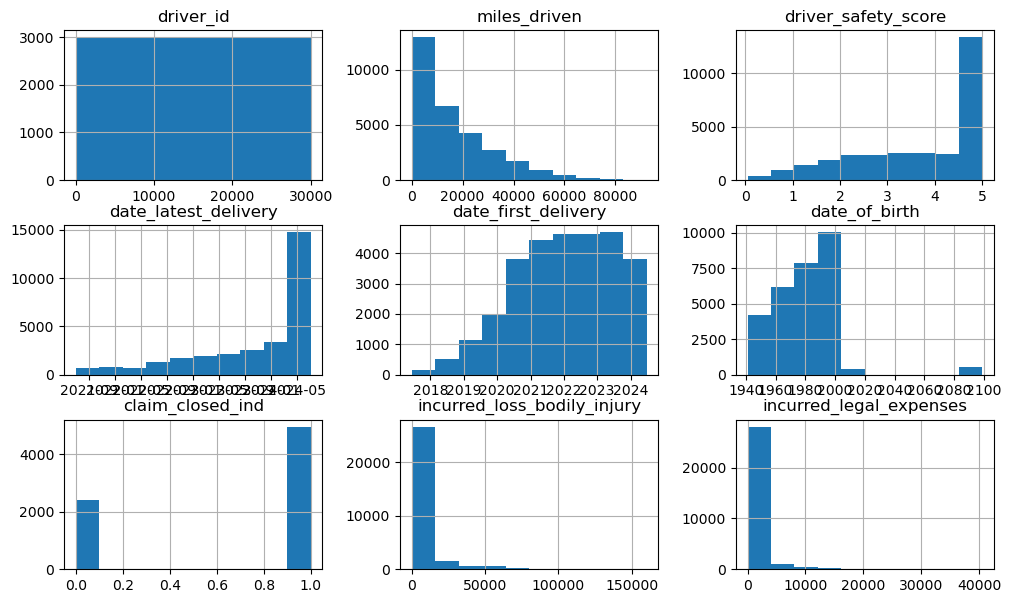

In [9]:
# Noticing point masses in driver_safety_score
# and date_latest_delivery, and erroneous
# values in date_of_birth
etl_train = etl(train)

etl_train.hist(figsize=(12,7))

array([[<Axes: title={'center': 'driver_id'}>,
        <Axes: title={'center': 'miles_driven'}>],
       [<Axes: title={'center': 'driver_safety_score'}>,
        <Axes: title={'center': 'date_latest_delivery'}>],
       [<Axes: title={'center': 'date_first_delivery'}>,
        <Axes: title={'center': 'date_of_birth'}>]], dtype=object)

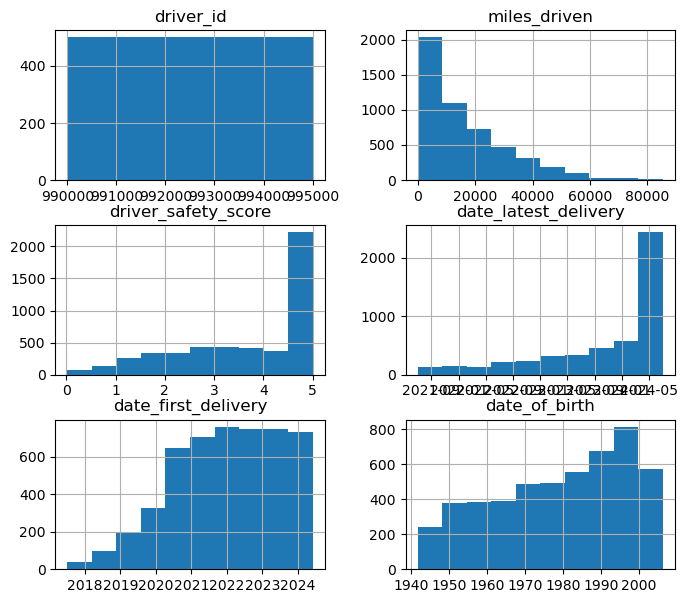

In [10]:
# Notice similar distributions
# between train and test (woo!)
etl_test = etl(test, training=False)

etl_test.hist(figsize=(8,7))

# Data Cleaning and Feature Engineering

In [14]:
def clean(df, training=True):
    
    if training:

        # Commercial auto liability GLMs almost always model ilae
        # TODO: Explore effects of splitting out incurred and dcc
        df['ilae'] = df['incurred_loss_bodily_injury'] + df['incurred_legal_expenses']

        # Commercial lines are typically not interested 
        # in modeling "frequent fliers" (i.e. drivers with 
        # very low miles driven), so we're going to judgementally   
        # drop records with less than 200 miles driven.   
        # This approach also helps improve model stability.
        freq_fliers = df.loc[df['miles_driven'] < 200].copy()
        df = df.loc[df['miles_driven'] >=200].copy()
        
        
        # One downside of pure premium models is that they
        # are more sensitive to outliers. As per CAS Monograph 5
        # Section 5.1.3, it's recommended to cap ILAE.
        loss_cap = df['ilae'].quantile(0.99)
        df['capped_ilae'] = np.where(df['ilae'] > loss_cap, loss_cap, df['ilae'])
        
    
        # We'll be fitting a tweedie distribution, 
        # so we'll create a pure premium column
        # TODO: Explore using separate freq/sev models as they can
        # have many benefits as per CAS Monograph 5 Section 5.1.1
        df['pure_prem'] = df['capped_ilae']/df['miles_driven']

    
    # Bin records by years of delivery experience
    df['driver_exp_years'] = (((df['date_latest_delivery']-df['date_first_delivery'])
                                  / datetime.timedelta(days=365))
                                 .apply(np.floor))

    
    # Convert DOB to age
    df['driver_age'] = ((datetime.datetime.now()-df['date_of_birth'])/datetime.timedelta(days=365)).apply(np.floor)

    
    # Convert negative ages to NaNs
    df['driver_age'] = df['driver_age'].mask(df['driver_age'] < 0)

    
    # Since we are not trending or developing the data, we can try including
    # a temporal control variable as per CAS Monograph 5 Section 5.1.3.
    # I've selected to use the date_latest_delivery field as it can
    # be used as a proxy for calendar/accident year.
    df['latest_deliv_year_control'] = 2024 - df['date_latest_delivery'].dt.year
    
    # TODO: An initial model pass with the control variable above
    # has a large leveraging effect on the model coefficients.
    # Going to exclude it for now, but we'll want to revisit
    # having a temporal control variable in future iterations
    # e.x. calendar quarters instead of years

    
    # Drop all na's from the other predictor columns
    # TODO: Explore imputing for vehicle_type and driver_exp_years with more time
    df = df.dropna(subset=['vehicle_type','driver_exp_years'])

    # Judgementally selected driver safety score bins to
    # promote model stability
    df['driver_safety_score_bin'] = pd.cut(df['driver_safety_score'],[0,2.5,3.5,4.5,5],labels=False)

    return df.copy()

In [16]:
clean_train = clean(etl_train)
clean_test = clean(etl_test, training=False)

## DCC Ratio

In [19]:
# Since we're asked to predict both incurred losses and incurred dcc,
# let's judgementally decide on a dcc allocation ratio

# TODO: Although we'll have a temporal control variable
# to help handle changes in loss and dcc trends, having
# a more in-depth dcc study would be helpful for 
# future model interations.
dcc_ratio = round(clean_train['incurred_legal_expenses'].sum()/clean_train['capped_ilae'].sum(),3)

print(dcc_ratio)

0.104


## Binning with Missing Data

In [22]:
# Lets take a quick look at binning driver_age
clean_train.isna().sum()

driver_id                          0
miles_driven                       0
vehicle_type                       0
driver_safety_score                0
date_latest_delivery               0
date_first_delivery                0
date_of_birth                    743
claim_closed_ind               22298
incurred_loss_bodily_injury        0
incurred_legal_expenses            0
ilae                               0
capped_ilae                        0
pure_prem                          0
driver_exp_years                   0
driver_age                      1219
latest_deliv_year_control          0
driver_safety_score_bin            0
dtype: int64

In [24]:
def quantile_cut(df, col, q):
    '''Bin continous predictor variable and 
    group missing values with the bin that
    has the most similar pure premium as
    per CAS monograph 5 section 4.2'''
    
    # As per CAS monograph 5 section 4.2, we can handle missing
    # data by grouping missing values with the bin that has to most similar
    # pure premium and include an error flag column as a control variable
    # to proxy the presence of the error

    #TODO: Explore multivariate imputation methods like MICE

    df[f'{col}_bin'] = pd.qcut(df[col], q, labels=False, precision=0)

    agg_data = df.groupby(f'{col}_bin', as_index=False)[['capped_ilae','miles_driven']].sum()

    agg_data['pp'] = agg_data['capped_ilae']/agg_data['miles_driven']

    agg_na = df[['capped_ilae','miles_driven']].loc[df[f'{col}_bin'].isna()].sum()

    nan_pp = agg_na.iloc[0]/agg_na.iloc[1]

    print(agg_data)

    print(f'NaN pure premium: {round(nan_pp,2)}')

    nan_close_bin = agg_data[f'{col}_bin'].iloc[(agg_data['pp']-nan_pp).abs().argsort()[1]]

    print(f'grouping NaNs with group: {nan_close_bin}')

    df[f'{col}_nan_flag'] = np.where(df[col].isna(), 1, 0)

    df[f'{col}_bin'] = df[f'{col}_bin'].fillna(nan_close_bin)

    return df

In [26]:
grouped_train = quantile_cut(clean_train, 'driver_age', 10)

   driver_age_bin   capped_ilae  miles_driven   pp
0            0.00 57,724,452.56 32,799,318.00 1.76
1            1.00 31,775,532.60 43,993,211.00 0.72
2            2.00 25,144,319.01 47,058,169.00 0.53
3            3.00 12,544,863.37 45,256,895.00 0.28
4            4.00  6,257,720.01 39,426,241.00 0.16
5            5.00  4,616,344.84 46,232,000.00 0.10
6            6.00  2,540,541.24 50,026,586.00 0.05
7            7.00    842,711.24 43,172,888.00 0.02
8            8.00    531,547.61 47,755,290.00 0.01
9            9.00     68,045.48 46,814,156.00 0.00
NaN pure premium: 0.82
grouping NaNs with group: 2.0


## Check for Collinearity with Cramer's V

In [29]:
# Before deciding on a model form, we should
# check the Cramer's V between each predictor 
# variable to seee if collinearity will be
# a problem

predictors = grouped_train[['vehicle_type',
                            'driver_safety_score_bin',
                            'driver_age_bin',
                            'driver_exp_years']].copy()

label = preprocessing.LabelEncoder()

predictors['vehicle_type'] =label.fit_transform(predictors['vehicle_type'])

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))


rows= []

for var1 in predictors:
  col = []
  for var2 in predictors :
    cramers =cramers_V(predictors[var1], predictors[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = predictors.columns, index =predictors.columns)

df

,vehicle_type,driver_safety_score_bin,driver_age_bin,driver_exp_years
vehicle_type,1.00,0.06,0.05,0.01
driver_safety_score_bin,0.06,1.00,0.81,0.07
driver_age_bin,0.05,0.81,1.00,0.11
driver_exp_years,0.01,0.07,0.11,1.00


In [31]:
# The standard is to address variables with a Cramer's V > 0.4,
# so we'll judgementally decide to remove driver_age_bin since
# driver_safety_score picks up most of the information anyway
predictor_cols = ['vehicle_type_bicycle',
                  'vehicle_type_electric vehicle',
                  'vehicle_type_motorcycle',
                  'vehicle_type_truck',
                  'driver_safety_score_bin',
                  'driver_exp_years',
                  #'driver_age_bin',
                  #'latest_deliv_year_control'
                 ]

In [33]:
# One-hot encode vehicle type and filter for predictor columns
X_train = (pd.get_dummies(grouped_train, 
                          columns=['vehicle_type'], 
                          drop_first=False, 
                          dtype=int)
           [predictor_cols])

X_test= (pd.get_dummies(clean_test, 
                        columns=['vehicle_type'], 
                        drop_first=False, 
                        dtype=int)
           [predictor_cols])

# Model Fitting and Analysis

In [36]:
# Fit a tweedie model to the training data
# wtih a judgementally selected power of 1.6
# as per CAS Monograph 5 Section 2.7.3

# TODO: Although the power usuall doesn't affect
# tweedie models too much, performing a grid search
# for the optimal power would help future iterations
tweedie_model = sm.GLM(grouped_train['pure_prem'],X_train, family=sm.families.Tweedie(var_power=1.6))

tweedie_results = tweedie_model.fit()

# Model shows pretty good z-scores (albeit in-sample)
# TODO: Select model form using forward or backward stepwise
tweedie_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              pure_prem   No. Observations:                28379
Model:                            GLM   Df Residuals:                    28373
Model Family:                 Tweedie   Df Model:                            5
Link Function:                    Log   Scale:                          22.228
Method:                          IRLS   Log-Likelihood:                -28262.
Date:                Thu, 10 Oct 2024   Deviance:                       69530.
Time:                        16:33:08   Pearson chi2:                 6.31e+05
No. Iterations:                    54   Pseudo R-squ. (CS):             0.1066
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
vehicle_type_bicycle              0.7600      0.102      7.440      0.000       0.560       0.960
vehicle_type_electric vehicle     0.8285      0.096      8.643      0.000       0.641       1.016
vehicle_type_motorcycle           0.5571      0.102      5.453      0.000       0.357       0.757
vehicle_type_truck                0.7133      0.123      5.811      0.000       0.473       0.954
driver_safety_score_bin          -1.9658      0.037    -52.725      0.000      -2.039      -1.893
driver_exp_years                  0.1933      0.031      6.233      0.000       0.132       0.254
=================================================================================================
"""

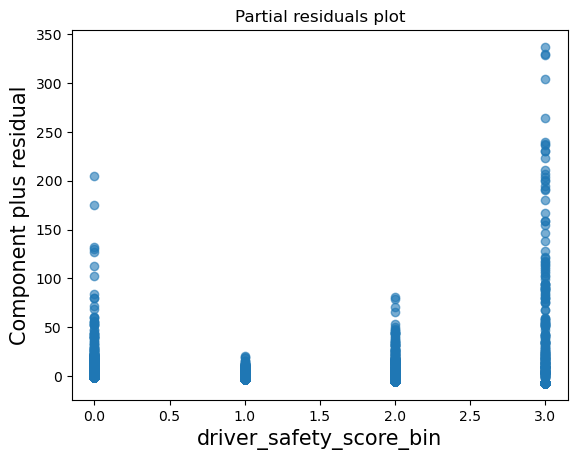

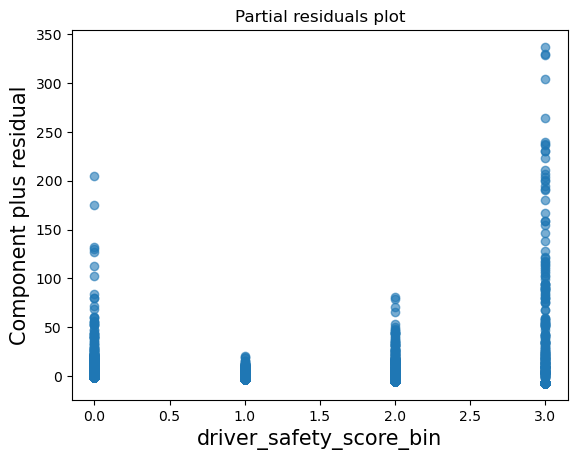

In [37]:
# TODO: Spot checking the partial residuals, may
# want to include something like a polynomial
# term or hinge function to driver safety
tweedie_results.plot_partial_residuals('driver_safety_score_bin')

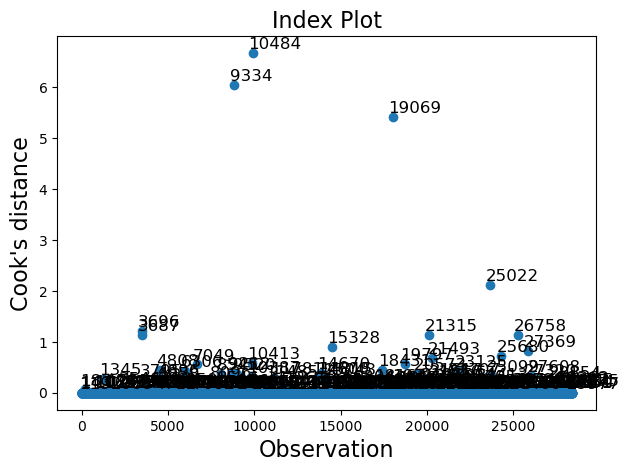

In [38]:
# TODO: There are a couple observations with a high 
# Cook's distance, will want to revisit with more time
get_inf = tweedie_results.get_influence()
fig = get_inf.plot_index(y_var="cooks", threshold=3 * get_inf.cooks_distance[0].mean())
fig.tight_layout(pad=1.0)

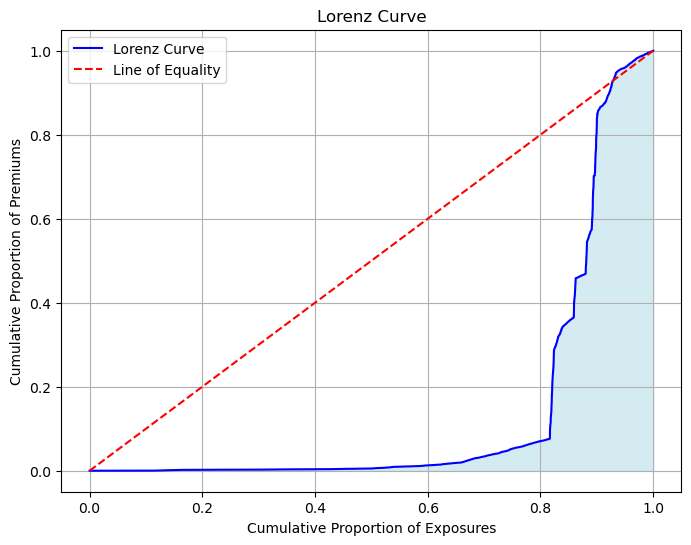

Gini Index: 0.7193654031629798


In [40]:
def lorenz_curve_gini(rankings, exposures, pure_premiums):
    # Step 1: Calculate the total premium and exposure
    total_exposure = np.sum(exposures)
    total_premium = np.sum(pure_premiums)

    # Step 2: Calculate the proportion of exposures and premiums
    sorted_indices = np.argsort(rankings)
    sorted_exposures = exposures[sorted_indices]
    sorted_premiums = pure_premiums[sorted_indices]

    cumulative_exposure = np.cumsum(sorted_exposures)
    cumulative_premium = np.cumsum(sorted_premiums)

    # Normalize to get the cumulative proportions
    L_x = cumulative_exposure / total_exposure
    L_y = cumulative_premium / total_premium

    # Step 3: Calculate Gini index
    # The Gini index is calculated as:
    # G = 1 - 2 * Area under the Lorenz curve
    # Area under the Lorenz curve can be approximated using trapezoidal rule
    area_under_lorenz = np.trapz(L_y, L_x)
    gini_index = 1 - 2 * area_under_lorenz

    # Step 4: Plot the Lorenz curve
    plt.figure(figsize=(8, 6))
    plt.plot(L_x, L_y, label='Lorenz Curve', color='blue')
    plt.plot([0, 1], [0, 1], label='Line of Equality', linestyle='--', color='red')
    plt.fill_between(L_x, L_y, color='lightblue', alpha=0.5)
    plt.title('Lorenz Curve')
    plt.xlabel('Cumulative Proportion of Exposures')
    plt.ylabel('Cumulative Proportion of Premiums')
    plt.legend()
    plt.grid()
    plt.show()

    return gini_index


gini_index = lorenz_curve_gini(rankings=np.array(tweedie_results.predict()),
                               exposures=np.array(clean_train['miles_driven']),
                               pure_premiums = np.array(clean_train['pure_prem']))
print(f'Gini Index: {gini_index}')

# Although the gini is calculated using in-sample data,
# we're able to get a fair bit of segmentation
# TODO: Use out-of-sample data

# Create Test Data Predictions

In [45]:
clean_test['pred_pp'] = tweedie_results.predict(X_test)

clean_test['pred_ilae'] = clean_test['pred_pp']*clean_test['miles_driven']

# Allocate losses and expenses using the dcc_ratio from earlier
clean_test['predicted_loss'] = clean_test['pred_ilae']*(1-dcc_ratio)
clean_test['predicted_expenses'] = clean_test['pred_ilae']*(dcc_ratio)

In [47]:
# Quickly comparing ilae between
# train and test, and we seem to
# be in the ballpark
(clean_train[['pure_prem',
              'incurred_loss_bodily_injury',
              'incurred_legal_expenses']]
 .loc[clean_train['pure_prem']>0]
 .describe())

,pure_prem,incurred_loss_bodily_injury,incurred_legal_expenses
count,"6,081.00","6,081.00","6,081.00"
mean,3.03,"23,724.83","2,662.86"
std,10.37,"22,202.94","4,068.03"
min,0.04,"2,922.00",30.18
25%,0.35,"9,545.00",204.94
50%,0.84,"14,261.00",401.66
75%,2.10,"25,000.00","3,903.40"
max,242.21,"160,007.00","38,005.09"


In [49]:
(clean_test[['pred_pp',
             'predicted_loss',
             'predicted_expenses']]
 .loc[clean_test['pred_pp']>0]
 .describe())

,pred_pp,predicted_loss,predicted_expenses
count,"5,000.00","5,000.00","5,000.00"
mean,0.55,"8,443.18",980.01
std,0.96,"22,718.62","2,636.98"
min,0.00,0.00,0.00
25%,0.01,61.20,7.10
50%,0.04,326.69,37.92
75%,0.47,"4,510.55",523.55
max,4.96,"232,614.08","26,999.85"


In [51]:
clean_test.to_csv('test_preds.csv')